In [17]:
#!/usr/bin/env python

import re
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scott as st
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Training MNIST Model on {device}\n{"=" * 44}')

Training MNIST Model on cpu


In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [19]:
def parse(newick):
    tokens = re.findall(r"([^:;,()\s]*)(?:\s*:\s*([\d.]+)\s*)?([,);])|(\S)", newick + ";")
    def recurse(nextid=0, parentid=-1):  # one node
        thisid = nextid;
        children = []

        name, length, delim, ch = tokens.pop(0)
        if ch == "(":
            while ch in "(,":
                node, ch, nextid = recurse(nextid + 1, thisid)
                children.append(node)
            name, length, delim, ch = tokens.pop(0)
        return {"id": thisid, "name": name, "length": float(length) if length else None,
                "parentid": parentid, "children": children}, delim, nextid

    return recurse()[0]


def molecule_to_networkxGraph(filename):
    compounds = st.parse.from_sdf(
        file_path=filename, ignore_hydrogens=True)[0]
    simple_cgraph = str(st.canonize.to_cgraph(compounds))
    gr = [parse(simple_cgraph)]
    mol = nx.DiGraph()
    nodeDict = {}
    for g in gr:
        nodeDict[g["id"]] = g["name"]
        mol.add_node(g["id"])
        mol.nodes[g["id"]]["atom"] = g["name"]
        if len(g["children"]) > 0:
            for child in g["children"]:
                if child["name"]!= "":
                    nodeDict[child["id"]] = child["name"]
                    mol.add_edge(child["id"], child["parentid"], weight=child["length"])
                    mol.nodes[child["id"]]["atom"] = child["name"]
                    gr.append(child)
    return mol


In [20]:
def load_true_value(base, filenamepath):
    Y = {}
    datasetname = []
    filenamepath = base + filenamepath
    filehandle = open(filenamepath, 'r')
    while True:
        # read a single line
        line = filehandle.readline()
        if not line:
            break
        value = line.split(' ')
        if (int(value[1])==-1):
                Y[value[0]] = torch.Tensor([0])
        if (int(value[1])==1):
            Y[value[0]] = torch.Tensor([int(value[1])])
        datasetname.append(base + value[0])
    # close the pointer to that file
    filehandle.close()
    return datasetname, Y

In [21]:
rootDir = './PAH/'
i=0
trainFile = "trainset_"+str(i)+".ds"
testFile = "testset_"+str(i)+".ds"
y=load_true_value(rootDir,testFile)
print(y)



(['./PAH/2-methylbenzo[c]phenanthrene.ct', './PAH/3-methylbenz[a]anthracene.ct', './PAH/tribenzo[a,e,i]pyrene.ct', './PAH/1,3-dimethylbenzo[a]pyrene.ct', './PAH/8-methylbenzo[a]pyrene.ct', './PAH/10-methylbenzo[a]pyrene.ct', './PAH/10-methylbenz[a]anthracene.ct', './PAH/1,6-dimethylbenzo[a]pyrene.ct', './PAH/2-methylbenzo[a]pyrene.ct', './PAH/benzo[e]pyrene.ct'], {'2-methylbenzo[c]phenanthrene.ct': tensor([1.]), '3-methylbenz[a]anthracene.ct': tensor([0.]), 'tribenzo[a,e,i]pyrene.ct': tensor([1.]), '1,3-dimethylbenzo[a]pyrene.ct': tensor([1.]), '8-methylbenzo[a]pyrene.ct': tensor([0.]), '10-methylbenzo[a]pyrene.ct': tensor([1.]), '10-methylbenz[a]anthracene.ct': tensor([1.]), '1,6-dimethylbenzo[a]pyrene.ct': tensor([1.]), '2-methylbenzo[a]pyrene.ct': tensor([1.]), 'benzo[e]pyrene.ct': tensor([1.])})


In [41]:
def dict_of_file_name_list(base, datasetname):
    GraphsDictList = {}
    # construct graphs from every single .ct file
    for filename in datasetname:
        GraphsDictList[filename.replace(base, '')] = molecule_to_networkxGraph(filename.replace(".ct",".sdf"))
    return GraphsDictList


In [42]:
def dag_creator(GraphsDictList):
    finalGraphsDict = {}
    sorOrderedList = {}
    centers = {}
    depthNodes = {}
    atoms = {'C': [1, 0, 0, 0], 'S': [0, 1, 0, 0], 'O': [0, 0, 1, 0], 'N': [0, 0, 0, 1]}
    bondValue = {0: [0, 0, 0], 1: [0, 0, 1], 2: [0, 1, 0], 3: [0, 1, 1], 4: [1, 0, 0]}
    for g in GraphsDictList:
#         print(g)
        for node in GraphsDictList[g]: 
            atom=GraphsDictList[g].nodes[node]["atom"]
            if atom in atoms:
                attrs = {node: { 'attrA1': float(atoms[atom][0]),'attrA2': float(atoms[atom][1]), 'attrA3': float(atoms[atom][2]), 'attrA4': float(atoms[atom][3])}}
            else :
                attrs = {node: { 'attrA1':0.5,'attrA2': 0.5, 'attrA3': 0.5, 'attrA4': 0.5}}
            nx.set_node_attributes(GraphsDictList[g], attrs)
            bond=GraphsDictList[g].degree[node]
            attrs = {node: {'attrB1': bondValue[bond][0], 'attrB2': bondValue[bond][1], 'attrB3': bondValue[bond][2]}}
            nx.set_node_attributes(GraphsDictList[g], attrs)
#         print(nx.get_node_attributes(GraphsDictList[g],"attrB3"))
#         print(GraphsDictList[g])
        finalGraphsDict[g], sorOrderedList[g], depthNodes[g], centers[g] = to_dag(GraphsDictList[g])
    return finalGraphsDict, sorOrderedList, depthNodes, centers

In [43]:
def to_dag(G, plot=False):
    '''  docstring:
    converte un grafo aciclico in un grafo dag 
    con i rami già diretti verso il centro.
    Input : grafo indiretto da covertire
    Output : grafo dag con grafico
    '''
    if (plot):
        nx.draw(G, with_labels=True, with_attributes=True)
        plt.show()
    centerDict = {}
#     src = nx.center(G)
#     for center in src:
    graphOrderedNodeTrav = {}
#         T = nx.dfs_tree(G, source=center)
#         G.remove_edges_from(list(G.edges()))
#         G = G.to_directed()
#         G.add_edges_from(list(T.edges()))
    center=[n for n,d in G.out_degree() if d==0][0] 
#     print(center)
    G = G.reverse()
    depthList = nx.shortest_path_length(G,center)
#     print(depthList)
    G = G.reverse()
    for n in nx.lexicographical_topological_sort(G):
        if (G.in_degree(n) > 0):
            sonListOrdered = []
            for p in sorted(list(G.predecessors(n)), key=lambda x: G.nodes[x]['atom']):
                G.nodes[n]['atom'] = G.nodes[n]['atom'] + G.nodes[p]['atom']
                sonListOrdered.append(p)
            graphOrderedNodeTrav[n] = sonListOrdered
        else:
            graphOrderedNodeTrav[n] = []
    centerDict[G.nodes[center]['atom']] = G, graphOrderedNodeTrav, depthList, center
    return centerDict[min(centerDict.keys())]

In [44]:
def get_d_value(Graph):
    labelSizeX = 7
    G = list(Graph.values())
    maxM = -1
    for g in G:
        for n in g.nodes():
            maxM = (max(maxM, g.in_degree(n)))
            # Size of the node array
        D = maxM + 1 + labelSizeX
    return D, maxM

In [45]:
def create_graph_tensor(Graphs, bias, maxM, DValue):
    graphTensor = {}
    for g in Graphs.keys():
        G = Graphs[g]
        nodes = {}
        for n in nx.lexicographical_topological_sort(G):
            x = torch.zeros(DValue, dtype=torch.float)
            x[0] = bias
            X = [G.nodes[n].pop('attrA1'), G.nodes[n].pop('attrA2'), G.nodes[n].pop('attrA3'), G.nodes[n].pop('attrA4'), G.nodes[n].pop('attrB1'),
                 G.nodes[n].pop('attrB2'), G.nodes[n].pop('attrB3')]
            if (len(X) > 0):
                i = maxM + 1
                for att in X:
                    x[i] = att
                    i = i + 1
            nodes[n] = x.view(DValue, 1)
        graphTensor[g] = nodes
    return graphTensor

In [46]:
def dataset_loader(depthNodes, centerNode, sorOrderedList, graphTensor, label, DValue, device):
    deepthdictBatchLabel = torch.zeros(0)
    deepthdictBatchTensor = {}
    deepthdictBatchParentListSons = {}
    dummyDict = {}

    for molecule in centerNode:
        deepthdictBatchLabel = torch.cat([deepthdictBatchLabel, label[molecule]])
        queue = []
        queue.append(centerNode[molecule])
        while (len(queue) > 0):
            current = queue.pop(0)
            depth = depthNodes[molecule][current]
            if depth in deepthdictBatchTensor.keys():
                deepthdictBatchTensor[depth] = torch.cat([deepthdictBatchTensor[depth], graphTensor[molecule][current]],
                                                         dim=0)
                deepthdictBatchParentListSons[depth].append(len(sorOrderedList[molecule][current]))
            else:
                deepthdictBatchTensor[depth] = graphTensor[molecule][current]
                deepthdictBatchParentListSons[depth] = [len(sorOrderedList[molecule][current])]
            queue.extend(sorOrderedList[molecule][current])
    dummyDict = {}
    for depth in reversed(range(1, len(
            deepthdictBatchParentListSons))):  # non considero il primo livello in quanto sicuramente non ha figli
        nodeOfNextLevel = len(deepthdictBatchParentListSons[depth - 1])
        nodeOfLevel = len(deepthdictBatchParentListSons[depth])
        dummy = torch.zeros(DValue * nodeOfNextLevel, nodeOfLevel)
        oriz = 0
        vert = 1
        for node in deepthdictBatchParentListSons[depth - 1]:
            vertTemp = vert
            for son in range(node):
                dummy[vertTemp][oriz] = 1
                oriz += 1
            vertTemp = +1
            vert += DValue
        dummyDict[depth - 1] = dummy.to_sparse().to(device)

    for depth in deepthdictBatchTensor:
        deepthdictBatchTensor[depth] = deepthdictBatchTensor[depth].to(device)

    deepthdictBatchLabel = deepthdictBatchLabel.view(-1, 1).to(device)
    return dummyDict, deepthdictBatchTensor, deepthdictBatchLabel

In [47]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()  # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size,
                             bias=False)  # 1st Full-Connected Layer:  (input data) ->  (hidden node)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(hidden_size, output_size,
                             bias=False)  # 2nd Full-Connected Layer:  (hidden node) ->  (output class)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.Relu = nn.ReLU()
        
        self.fc1Root = nn.Linear(input_size, hidden_size,
                                 bias=False)  # 1st Full-Connected Layer:  (input data) ->  (hidden node)
        nn.init.kaiming_normal_(self.fc1Root.weight)
        
        self.fc2Root = nn.Linear(hidden_size, output_size,
                                 bias=False)  # 2nd Full-Connected Layer:  (hidden node) ->  (output class)
        nn.init.kaiming_normal_(self.fc2Root.weight)
        self.Drop = nn.Dropout(0.15)
        self.ReluRoot = nn.ReLU()
        
#         self.sig=nn.Sigmoid()
#         self.sigRoot=nn.Sigmoid()
        

    def forward(self, batchTensor, deep):
        if deep != 0:
            out = self.fc1(batchTensor)
            out = self.Relu(out)
            out = self.Drop(out)
            out = self.fc2(out)
            return out
        else: #root node utilized to prdict
            out = self.fc1Root(batchTensor)
            out = self.ReluRoot(out)
            out = self.Drop(out)
            out = self.fc2Root(out)
            return out


In [48]:
def train(net, dataSetTrain, dataSetTest, optimizer, num_epochs, DValue,criterion):
    # # Training loop
    m = nn.Softmax(dim=1)
    RMSETrain = []
    RMSETest = []
    start = time.time()
    losses = 0
    y_true = []
    y_pred = []
    lossesA = []
    dummyDict, deepthdictBatchTensor, deepthdictBatchLabel = dataSetTrain
    for epoch in range(num_epochs):
        leafIndex = len(deepthdictBatchTensor) - 1
        res = net(deepthdictBatchTensor[leafIndex].view(-1, DValue), leafIndex)
        for depth in reversed(range(0, len(deepthdictBatchTensor) - 1)):
            res = net(torch.sparse.addmm(deepthdictBatchTensor[depth], dummyDict[depth], res).view(-1, DValue), depth)
        losses = criterion(res, deepthdictBatchLabel)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        plt.plot(losses.item())
        lossesA.append(losses)
        if (epoch + 1) % (int(num_epochs / 1)) == 0:  # print every (num_epochs/10) epochs --> total 10 print
            print('TRAIN SET \nEpoch [%d/%d],  \nLOSS: %.5f \n '
                  % (epoch + 1, num_epochs, losses))
            RMSETest.append(predict(net, dataSetTest, DValue,criterion, rmse=True))
            RMSETrain.append((losses))
            pred = np.round(res.detach().numpy())
            target = deepthdictBatchLabel.float()
            y_true.extend(deepthdictBatchLabel.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    plt.plot(lossesA)
    plt.show()
    end = time.time()
    training_time = end - start
    print('Tempo di training ', training_time)
    print('FINE TRAINING')
    print('\n+++++++++++++++++++++++++++++++++++++++\n\n')
    print('LOSSTest', RMSETest)
    print('LOSSTrain', RMSETrain)
    return RMSETrain, RMSETest, training_time

In [49]:
def predict(net, dataSetTrain, DValue,criterion, rmse=False):
    m = nn.Softmax(dim=1)
    avg_error = 0
    with torch.no_grad():
        lossesMean = 0
        result = 0
        dummyDict, deepthdictBatchTensor, deepthdictBatchLabel = dataSetTrain
        leafIndex = len(deepthdictBatchTensor) - 1
        result = net(deepthdictBatchTensor[leafIndex].view(-1, DValue), leafIndex)
        for depth in reversed(range(0, len(deepthdictBatchTensor) - 1)):
            result = net(torch.addmm(deepthdictBatchTensor[depth], dummyDict[depth], result).view(-1, DValue), depth)
        print(result)
        print(m(result))
        print(deepthdictBatchLabel)
        lossesMean = criterion(result, deepthdictBatchLabel)
    print('VALIDATION SET ')
    print('LOSS: ', (lossesMean))
    
    if (rmse):
        return (lossesMean)
    else:
        for i in range(len(deepthdictBatchLabel)):
            deepthdictBatchLabel[i] = deepthdictBatchLabel[i].item()
        return result.view(-1).tolist(), deepthdictBatchLabel.cpu(), avg_error

trainset_0.ds
testset_0.ds
['./PAH/2-methylbenzo[c]phenanthrene.ct', './PAH/3-methylbenz[a]anthracene.ct', './PAH/tribenzo[a,e,i]pyrene.ct', './PAH/1,3-dimethylbenzo[a]pyrene.ct', './PAH/8-methylbenzo[a]pyrene.ct', './PAH/10-methylbenzo[a]pyrene.ct', './PAH/10-methylbenz[a]anthracene.ct', './PAH/1,6-dimethylbenzo[a]pyrene.ct', './PAH/2-methylbenzo[a]pyrene.ct', './PAH/benzo[e]pyrene.ct'] {'2-methylbenzo[c]phenanthrene.ct': tensor([1.]), '3-methylbenz[a]anthracene.ct': tensor([0.]), 'tribenzo[a,e,i]pyrene.ct': tensor([1.]), '1,3-dimethylbenzo[a]pyrene.ct': tensor([1.]), '8-methylbenzo[a]pyrene.ct': tensor([0.]), '10-methylbenzo[a]pyrene.ct': tensor([1.]), '10-methylbenz[a]anthracene.ct': tensor([1.]), '1,6-dimethylbenzo[a]pyrene.ct': tensor([1.]), '2-methylbenzo[a]pyrene.ct': tensor([1.]), 'benzo[e]pyrene.ct': tensor([1.])}
TRAIN SET 
Epoch [10000/10000],  
LOSS: 0.60713 
 
tensor([[0.0000],
        [0.0000],
        [0.2709],
        [1.0907],
        [0.0000],
        [0.9422],
      

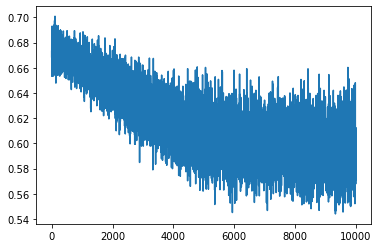

Tempo di training  109.89786100387573
FINE TRAINING

+++++++++++++++++++++++++++++++++++++++


LOSSTest [tensor(0.5850)]
LOSSTrain [tensor(0.6071, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)]
tensor([[0.0000],
        [0.2802],
        [1.0364],
        [1.5528],
        [0.0000],
        [1.4437],
        [0.4151],
        [0.7360],
        [0.6635],
        [0.0000]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
VALIDATION SET 
LOSS:  tensor(0.4944)
trainset_1.ds
testset_1.ds
['./PAH/anthra[1,2-a]anthracene.ct', './PAH/dibenzo[a,l]naphthacene.ct', './PAH/6-methylbenz[a]anthracene.ct', './PAH/2,3-dimethylbenzo[a]pyrene.ct', './PAH/4,5-dimethylbenzo[a]pyrene.ct', './PAH/12-methylbenzo[a]pyrene.ct', './PAH/dibenzo[c,g]phenanthrene.ct', './PAH/naphtho

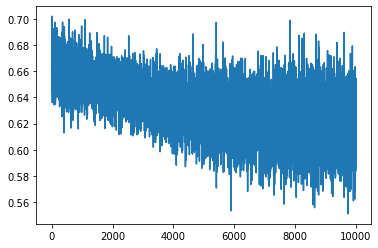

Tempo di training  109.27216720581055
FINE TRAINING

+++++++++++++++++++++++++++++++++++++++


LOSSTest [tensor(0.5561)]
LOSSTrain [tensor(0.6081, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)]
tensor([[ 0.1880],
        [-0.1844],
        [ 1.2204],
        [ 0.0000],
        [ 1.9154],
        [ 0.7449],
        [-0.2441],
        [-0.2695],
        [-0.2907],
        [ 0.0000]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]])
VALIDATION SET 
LOSS:  tensor(0.5541)
trainset_2.ds
testset_2.ds
['./PAH/5-methylbenz[a]anthracene.ct', './PAH/benzo[b]chrysene.ct', './PAH/11-methylbenzo[a]pyrene.ct', './PAH/perylene.ct', './PAH/6,8,12-trimethylbenz[a]anthracene.ct', './PAH/pentacene.ct', './PAH/4-methylchrysene.ct', './PAH/1-methylbenz[a]anthracene.ct', './PAH

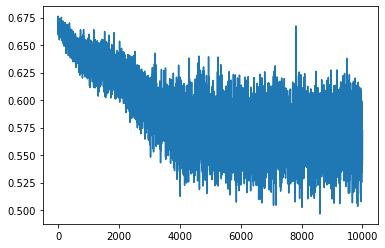

Tempo di training  105.18023085594177
FINE TRAINING

+++++++++++++++++++++++++++++++++++++++


LOSSTest [tensor(0.9850)]
LOSSTrain [tensor(0.5419, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)]
tensor([[1.3330],
        [0.4230],
        [0.0503],
        [0.4070],
        [1.7660],
        [0.0019],
        [1.3280],
        [0.8724],
        [1.5361],
        [0.0000]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]])
VALIDATION SET 
LOSS:  tensor(0.8812)
trainset_3.ds
testset_3.ds
['./PAH/1,2-dimethylbenzo[a]pyrene.ct', './PAH/6-methylanthanthrene.ct', './PAH/5-methylbenzo[c]phenanthrene.ct', './PAH/3-methylbenzo[a]pyrene.ct', './PAH/5-methylbenzo[a]pyrene.ct', './PAH/benzo[a]pyrene.ct', './PAH/benzo[a]naphthacene.ct', './PAH/dibenzo[c,i]pyrene.ct', '.

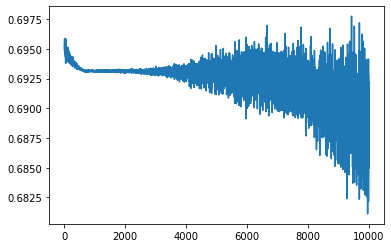

Tempo di training  106.28230738639832
FINE TRAINING

+++++++++++++++++++++++++++++++++++++++


LOSSTest [tensor(0.6685)]
LOSSTrain [tensor(0.6822, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)]
tensor([[ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.2164],
        [-0.2164],
        [ 0.2412],
        [ 0.0000],
        [-0.2164]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]])
VALIDATION SET 
LOSS:  tensor(0.6727)
trainset_4.ds
testset_4.ds
['./PAH/dibenzo[b,g]phenanthrene.ct', './PAH/6-methylbenzo[c]phenanthrene.ct', './PAH/12-methylbenz[a]anthracene.ct', './PAH/benzo[a]anthracene.ct', './PAH/naphtho[1,2-b]triphenylene.ct', './PAH/dibenz[a,c]anthracene.ct', './PAH/7-methylbenzo[a]pyrene.ct', './PAH/di

KeyboardInterrupt: 

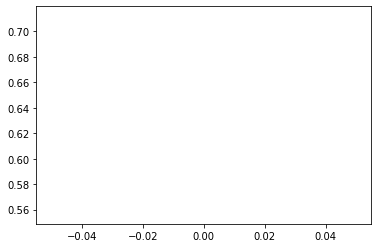

In [50]:
for i in range(10):
    num_epochs = 10000
    bias=1
    rootDir = './PAH/'
    trainFile = "trainset_"+str(i)+".ds"
    testFile = "testset_"+str(i)+".ds"
    device = torch.device("cpu")
    print(trainFile)
    print(testFile)
    datasetFilenameTrain, labelTrain = load_true_value(rootDir, trainFile)
    graphTrain, sorOrderedListTrain, depthNodesTrain, centerNodeTrain = dag_creator(
        dict_of_file_name_list(rootDir, datasetFilenameTrain))
    DTrain, maxMTrain = get_d_value(graphTrain)

    datasetFilenameTest, labelTest = load_true_value(rootDir, testFile)
    graphTest, sorOrderedListTest, depthNodesTest, centerNodeTest = dag_creator(dict_of_file_name_list(rootDir, datasetFilenameTest))
    DTest, maxMTest = get_d_value(graphTest)
    print(datasetFilenameTest, labelTest)

        
    DValue = max(DTrain, DTest)
    maxMValue = max(maxMTrain, maxMTest)

    graphTensorTrain = create_graph_tensor(graphTrain, bias, maxMValue, DValue)
    dataSetTrain = dataset_loader(depthNodesTrain, centerNodeTrain, sorOrderedListTrain, graphTensorTrain, labelTrain,
                                 DValue, device)

    graphTensorTest = create_graph_tensor(graphTest, bias, maxMValue, DValue)
    dataSetTest = dataset_loader(depthNodesTest, centerNodeTest, sorOrderedListTest, graphTensorTest, labelTest, DValue,
                                device)
    input_size = DValue  # The image size = 28 x 28 = 784
    hidden_size = 4  # The number of nodes at the hidden layer
    output_size = 1  # The number of output classes. In this case, from 0 to 9
    net = Net(input_size, hidden_size, output_size).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()
    
    RMSETrain, RMSETest, training_time = train(net, dataSetTrain, dataSetTest, optimizer, num_epochs, DValue,criterion)
    predicted, true, avg_error = predict(net, dataSetTest, DValue,criterion)
    

In [32]:
num_epochs = 10000
i=0
bias=1
rootDir = './PAH/'
trainFile = "trainset_"+str(i)+".ds"
testFile = "testset_"+str(i)+".ds"
device = torch.device("cpu")
print(trainFile)
print(testFile)

trainset_0.ds
testset_0.ds


In [33]:
    datasetFilenameTrain, labelTrain = load_true_value(rootDir, trainFile)
    graphTrain, sorOrderedListTrain, depthNodesTrain, centerNodeTrain = dag_creator(
        dict_of_file_name_list(rootDir, datasetFilenameTrain))
    DTrain, maxMTrain = get_d_value(graphTrain)

    datasetFilenameTest, labelTest = load_true_value(rootDir, testFile)
    graphTest, sorOrderedListTest, depthNodesTest, centerNodeTest = dag_creator(dict_of_file_name_list(rootDir, datasetFilenameTest))
    DTest, maxMTest = get_d_value(graphTest)

    DValue = max(DTrain, DTest)
    maxMValue = max(maxMTrain, maxMTest)

    graphTensorTrain = create_graph_tensor(graphTrain, bias, maxMValue, DValue)
    dataSetTrain = dataset_loader(depthNodesTrain, centerNodeTrain, sorOrderedListTrain, graphTensorTrain, labelTrain,
                                 DValue, device)

    graphTensorTest = create_graph_tensor(graphTest, bias, maxMValue, DValue)
    dataSetTest = dataset_loader(depthNodesTest, centerNodeTest, sorOrderedListTest, graphTensorTest, labelTest, DValue,
                                device)

In [39]:
    input_size = DValue  # The image size = 28 x 28 = 784
    hidden_size = 4  # The number of nodes at the hidden layer
    output_size = 1  # The number of output classes. In this case, from 0 to 9
    net = Net(input_size, hidden_size, output_size).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()


TRAIN SET 
Epoch [10000/10000],  
LOSS: 0.69315 
 
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
VALIDATION SET 
LOSS:  tensor(0.6931)


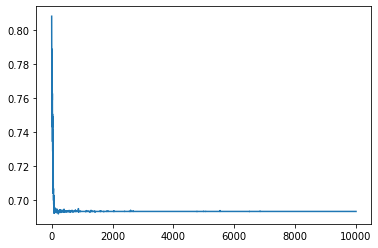

Tempo di training  109.11479353904724
FINE TRAINING

+++++++++++++++++++++++++++++++++++++++


LOSSTest [tensor(0.6931)]
LOSSTrain [tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)]
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
VALIDATION SET 
LOSS:  tensor(0.6931)


In [40]:
    RMSETrain, RMSETest, training_time = train(net, dataSetTrain, dataSetTest, optimizer, num_epochs, DValue,criterion)
    predicted, true, avg_error = predict(net, dataSetTest, DValue,criterion)
    